 Dataset organized by breed!
Dataset split into train and validation sets.
 Resized images in D:\Website Codes\dog-breed-identification\train to (224, 224).
 Resized images in D:\Website Codes\dog-breed-identification\valid to (224, 224).
Found 1558 files belonging to 120 classes.
Found 3674 files belonging to 120 classes.
 Dataset loaded successfully!
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                             

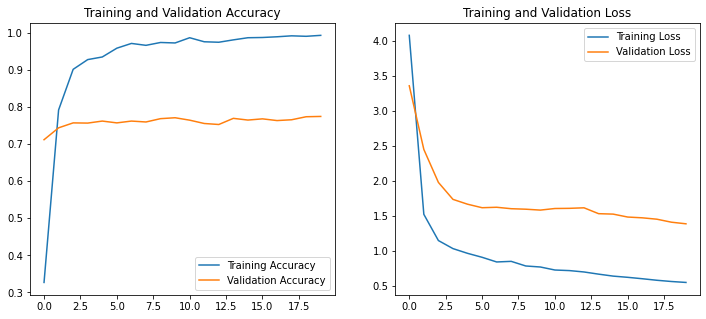

In [3]:
# Import Libraries
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt


base_dir = r'D:\Website Codes\dog-breed-identification'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
labels_path = os.path.join(base_dir, 'labels.csv')

def organize_dataset():
    """Organize images into breed-based folders."""
    labels_df = pd.read_csv(labels_path)

    # Create breed-based folders
    for _, row in labels_df.iterrows():
        img_file = row['id'] + '.jpg'
        breed = row['breed']

        breed_folder = os.path.join(train_dir, breed)
        os.makedirs(breed_folder, exist_ok=True)

        img_path = os.path.join(train_dir, img_file)
        if os.path.exists(img_path):
            shutil.move(img_path, os.path.join(breed_folder, img_file))

    print(" Dataset organized by breed!")

def split_dataset(split_ratio=0.2):
    """Split the dataset into training and validation sets."""
    if not os.path.exists(valid_dir):
        os.makedirs(valid_dir)

    for breed in os.listdir(train_dir):
        breed_path = os.path.join(train_dir, breed)
        valid_breed_path = os.path.join(valid_dir, breed)

        # Create validation folders
        os.makedirs(valid_breed_path, exist_ok=True)

        images = os.listdir(breed_path)
        train_imgs, valid_imgs = train_test_split(images, test_size=split_ratio, random_state=42)

        # Move validation images
        for img in valid_imgs:
            shutil.move(os.path.join(breed_path, img), os.path.join(valid_breed_path, img))

    print("Dataset split into train and validation sets.")

def resize_images(directory, target_size=(224, 224)):
    """Resize all images to (224, 224)."""
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img = img.resize(target_size)
                img.save(img_path)

    print(f" Resized images in {directory} to {target_size}.")

def load_dataset(batch_size=32, img_size=(224, 224)):
    """Load dataset into TensorFlow using image_dataset_from_directory."""
    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=train_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True
    )

    valid_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=valid_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )

    # Apply caching and prefetching
    train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    print(" Dataset loaded successfully!")
    return train_dataset, valid_dataset


def create_model(num_classes):
    """Create CNN model with EfficientNetB3 and regularization."""
    base_model = EfficientNetB3(
        weights='imagenet',  # Pre-trained weights
        input_shape=(224, 224, 3),
        include_top=False
    )
    base_model.trainable = False  # Freeze the base model

    # Build the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.3),  # Dropout for regularization
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    print(" Model compiled successfully!")
    return model


def train_model(model, train_dataset, valid_dataset, epochs=20):
    """Train the model with learning rate scheduling and early stopping."""
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=[reduce_lr, early_stopping]
    )

    print("Model training completed!")
    return history


def plot_results(history):
    """Plot accuracy and loss curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()



organize_dataset()


split_dataset()

resize_images(train_dir)
resize_images(valid_dir)

train_dataset, valid_dataset = load_dataset()

num_classes = len(os.listdir(train_dir))
model = create_model(num_classes)

history = train_model(model, train_dataset, valid_dataset)

plot_results(history)

